Install Dependencies

In [1]:
!pip install torch torchvision matplotlib

Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim  # Import optim for optimizer
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set the seed for reproducibility
import random
random.seed(42)

Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check using CPU/GPU

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

device =  cuda


Defining Parameters

In [5]:
batch_size = 32
learning_rate = 0.0001
num_epochs = 10

Define dataset paths & transformations

In [6]:
# Set the base directory for the dataset
base_dir = '/content/drive/MyDrive/Colab Notebooks/COS30049_CTIP_Assignment/Species_Detection_Model/Resnet_Dataset/'

# Set directories for training, validation, and test datasets
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Define image size for ResNet
image_size = 224

# Define transformations with resizing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets using ImageFolder with the updated transformations
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

# Create data loaders for training, validation, and test sets
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
}

Load a pretrained ResNet model and modify the final layer

In [7]:
# Load ResNet model (choose ResNet50, ResNet101, or another as per your needs)
model = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 64)  # Update final layer for 64 classes

# Move model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adjust learning rate as necessary

Model Training

In [8]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in tqdm(dataloaders['train'], desc=f"Epoch {epoch + 1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = correct / total

        # Validation loop
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(dataloaders['valid'].dataset)
        epoch_val_acc = correct_val / total_val

        # Record metrics
        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_acc)
        val_accs.append(epoch_val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}: '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs

train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10: 100%|██████████| 95/95 [00:51<00:00,  1.84it/s]


Epoch 1/10: Train Loss: 2.7370, Train Acc: 0.3499, Val Loss: 1.8453, Val Acc: 0.5076


Epoch 2/10: 100%|██████████| 95/95 [00:48<00:00,  1.95it/s]


Epoch 2/10: Train Loss: 1.2563, Train Acc: 0.7004, Val Loss: 1.2492, Val Acc: 0.6942


Epoch 3/10: 100%|██████████| 95/95 [00:49<00:00,  1.91it/s]


Epoch 3/10: Train Loss: 0.6437, Train Acc: 0.8523, Val Loss: 1.1785, Val Acc: 0.6881


Epoch 4/10: 100%|██████████| 95/95 [00:53<00:00,  1.77it/s]


Epoch 4/10: Train Loss: 0.3575, Train Acc: 0.9220, Val Loss: 1.0154, Val Acc: 0.7278


Epoch 5/10: 100%|██████████| 95/95 [00:49<00:00,  1.93it/s]


Epoch 5/10: Train Loss: 0.2294, Train Acc: 0.9537, Val Loss: 1.0201, Val Acc: 0.7370


Epoch 6/10: 100%|██████████| 95/95 [00:49<00:00,  1.92it/s]


Epoch 6/10: Train Loss: 0.1404, Train Acc: 0.9729, Val Loss: 0.8632, Val Acc: 0.7615


Epoch 7/10: 100%|██████████| 95/95 [00:49<00:00,  1.93it/s]


Epoch 7/10: Train Loss: 0.1028, Train Acc: 0.9808, Val Loss: 0.8582, Val Acc: 0.7706


Epoch 8/10: 100%|██████████| 95/95 [00:49<00:00,  1.94it/s]


Epoch 8/10: Train Loss: 0.0744, Train Acc: 0.9871, Val Loss: 0.8756, Val Acc: 0.8104


Epoch 9/10: 100%|██████████| 95/95 [00:51<00:00,  1.86it/s]


Epoch 9/10: Train Loss: 0.0429, Train Acc: 0.9934, Val Loss: 0.9634, Val Acc: 0.7706


Epoch 10/10: 100%|██████████| 95/95 [00:48<00:00,  1.94it/s]


Epoch 10/10: Train Loss: 0.0708, Train Acc: 0.9822, Val Loss: 0.9622, Val Acc: 0.7920


Model Testing

In [9]:
def evaluate_model(model):
    model.eval()  # Set the model to evaluate mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(dataloaders['test'].dataset)
    test_acc = correct / total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Evaluate the model
evaluate_model(model)

Test Loss: 0.8919, Test Accuracy: 0.7851


Display Predictions

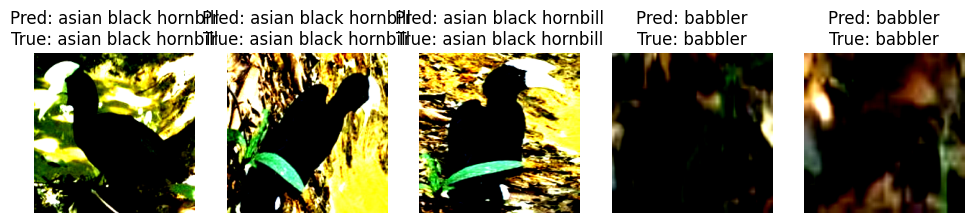

In [16]:
def display_predictions(model, dataloader, class_names, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch of images and labels
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient calculation
        outputs = model(images)  # Get predictions
        _, preds = torch.max(outputs, 1)  # Get predicted classes

    # Convert images to CPU and numpy arrays for plotting
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    # Convert images to the correct format for display
    images = np.clip(images, 0, 1)  # Ensure the pixel values are between 0 and 1

    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))  # Rearrange the image dimensions
        plt.title(f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}')
        plt.axis('off')
    plt.show()

#Display Predictions
display_predictions(model, dataloaders['test'], image_datasets['train'].classes, num_images=5)

Plot Metrics

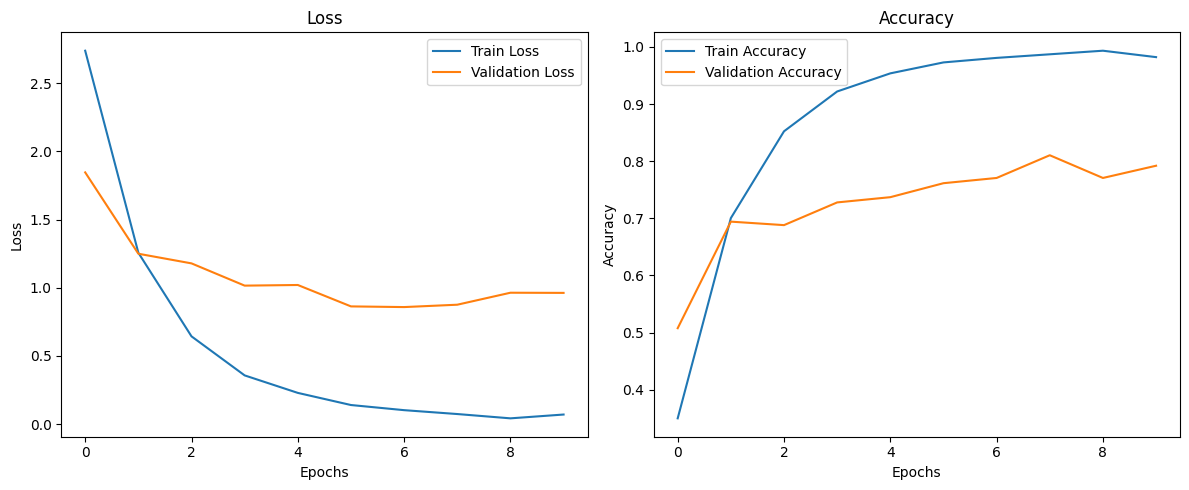

In [10]:
# Plotting the training and validation loss/accuracy
def plot_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_history(train_losses, val_losses, train_accs, val_accs)

Save Model

In [13]:
save_path = '/content/drive/MyDrive/Colab Notebooks/COS30049_CTIP_Assignment/Species_Detection_Model/resnet50_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f'Model saved to {save_path}')

Model saved to /content/drive/MyDrive/Colab Notebooks/COS30049_CTIP_Assignment/Species_Detection_Model/resnet50_model.pth


Inference

<ipython-input-27-a366170d62e8>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))  # Load the saved weights


Predicted: thick-spined porcupine, True: thick-spined porcupine


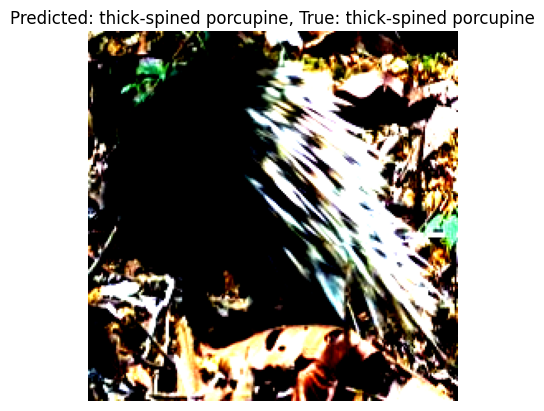

In [27]:
import random
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the saved model
model = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 64)  # Ensure this matches your model's output
model.load_state_dict(torch.load(save_path))  # Load the saved weights
model.to(device)  # Move to the appropriate device
model.eval()  # Set the model to evaluation mode

# Select a random image from the test dataset
random_index = random.randint(0, len(image_datasets['test']) - 1)
random_image, true_label = image_datasets['test'][random_index]  # Get a random image and its label

# Ensure the image is a 3D tensor
if random_image.ndim == 3:
    random_image = random_image.unsqueeze(0)  # Add batch dimension

# Move the image to the appropriate device
random_image = random_image.to(device)

# Run inference
with torch.no_grad():  # Disable gradient calculation
    outputs = model(random_image)  # Get predictions
    _, predicted = torch.max(outputs, 1)  # Get predicted class

# Print the result
class_names = image_datasets['train'].classes  # Get the class names from the training dataset
predicted_label = class_names[predicted.item()]
true_label_name = class_names[true_label]

print(f'Predicted: {predicted_label}, True: {true_label_name}')

# Display the image
# If the random_image is a tensor, convert it back to NumPy array for display
if random_image.ndim == 4:  # If it has a batch dimension
    random_image = random_image.squeeze(0)  # Remove batch dimension

# Move image to CPU and convert to NumPy for visualization
random_image_np = random_image.cpu().numpy()
random_image_np = np.clip(random_image_np, 0, 1)  # Ensure the pixel values are between 0 and 1

plt.imshow(np.transpose(random_image_np, (1, 2, 0)))  # Rearrange dimensions for display
plt.title(f'Predicted: {predicted_label}, True: {true_label_name}')
plt.axis('off')
plt.show()